In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the scaler bundle once
scaler_bundle = joblib.load("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/standard_scaler_bundle.joblib")
X_train_fit_selected_scaled = scaler_bundle["X_train_fit_selected_scaled"]
X_val_selected_scaled = scaler_bundle["X_val_selected_scaled"]
X_test_selected_scaled = scaler_bundle["X_test_selected_scaled"]

# load the splits bundle once
splits_bundle = joblib.load("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/splits_bundle.joblib")
y_train_fit = splits_bundle["y_train_fit"]
y_val = splits_bundle["y_val"]
y_test = splits_bundle["y_test"]

In [4]:
majority_count = Counter(y_train_fit)[0]

In [5]:
sampling_strategy = {
    2: int(majority_count * 0.02),   # 2% of majority class
    3: int(majority_count * 0.02),   # 2% of majority class
    5: int(majority_count * 0.01),   # 1% of majority class
    6: int(majority_count * 0.01)    # 1% of majority class
}

In [6]:
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=101, k_neighbors=3)

In [7]:
X_train_smote, y_train_smote = smote.fit_resample(X_train_fit_selected_scaled, y_train_fit)

In [8]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(1567705, 40)
(1567705,)


In [9]:
num_classes = len(np.unique(y_train_fit))
print(num_classes)

7


In [10]:
cw_arr = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=y_train_fit)
class_weights = {i: float(w) for i, w in enumerate(cw_arr)}
print(class_weights)

{0: 0.16469336313922708, 1: 2.16655959115566, 2: 913.8976088289393, 3: 2087.6288515406163, 4: 2.1528474659502868, 5: 3226.335497835498, 6: 6083.94693877551}


In [11]:
n_features = X_train_smote.shape[1]
print(n_features)

40


In [12]:
X_tr_seq = X_train_smote.to_numpy().reshape((-1, n_features, 1))
# reshapes the train matrix to so Conv1D can treat the 40 features as a 1d sequence
print(X_tr_seq.shape)
X_val_seq = X_val_selected_scaled.to_numpy().reshape((-1, n_features, 1))
# reshapes the validation matrix the same way
print(X_val_seq.shape)
X_test_seq = X_test_selected_scaled.to_numpy().reshape((-1, n_features, 1))
# reshapes the test matrix likewise, test is the final holdout set used once at the end.
print(X_test_seq.shape)

(1567705, 40, 1)
(263042, 40, 1)
(438403, 40, 1)


In [14]:
y_tr_cat = keras.utils.to_categorical(y_train_smote, num_classes=num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=num_classes)
# turns integer labels into one-hot vectors for categorical cross entropy.

In [16]:
inputs = keras.Input(shape=(n_features, 1))

# Block 1
x = layers.Conv1D(64, 7, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Dropout(0.15)(x)

# Block 2
x = layers.Conv1D(128, 5, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Dropout(0.15)(x)

# Block 3
x = layers.Conv1D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.25)(x)

logits = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=logits)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 40, 64)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,751 (686.53 KB)

 Trainable params: 174,855 (683.03 KB)

 Non-trainable params: 896 (3.50 KB)

In [17]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics=[keras.metrics.CategoricalAccuracy(name="acc")])


In [62]:
ckpt_path = "/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/models/cnn_model.keras"
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.000001, verbose=1)

In [19]:
history = model.fit(
    X_tr_seq, y_tr_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop, ckpt, rlrop],
    verbose=1
)


Epoch 1/100
6124/6124 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - acc: 0.9724 - loss: 0.0928 - val_acc: 0.9964 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 2/100
6124/6124 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.9886 - loss: 0.0351 - val_acc: 0.9973 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 3/100
6124/6124 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.9897 - loss: 0.0315 - val_acc: 0.9966 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 4/100
6124/6124 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.9901 - loss: 0.0298 - val_acc: 0.9977 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 5/100
6124/6124 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.9905 - loss: 0.0287 - val_acc: 0.9976 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 6/100
6124/6124 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.9908 - loss: 0.0274 - val_acc: 0.8738 - val_loss: 0.6623 - learning_rate: 0.0010
Epoch 7/100
6124/6124 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.9909 - loss: 0.0268 - val_acc: 0.9975 - val_loss: 0.0103 - 

In [64]:
best_model.save("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/models/cnn_model.keras")

In [65]:
best_model = keras.models.load_model(ckpt_path)
val_loss, val_acc = best_model.evaluate(X_val_seq, y_val_cat, batch_size=512, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test_seq, y_test_cat, batch_size=512, verbose=0)

print({"val_loss": val_loss, "val_acc": val_acc, "test_loss": test_loss, "test_acc": test_acc})


{'val_loss': 0.009365608915686607, 'val_acc': 0.9977228045463562, 'test_loss': 0.009659013710916042, 'test_acc': 0.9976893663406372}


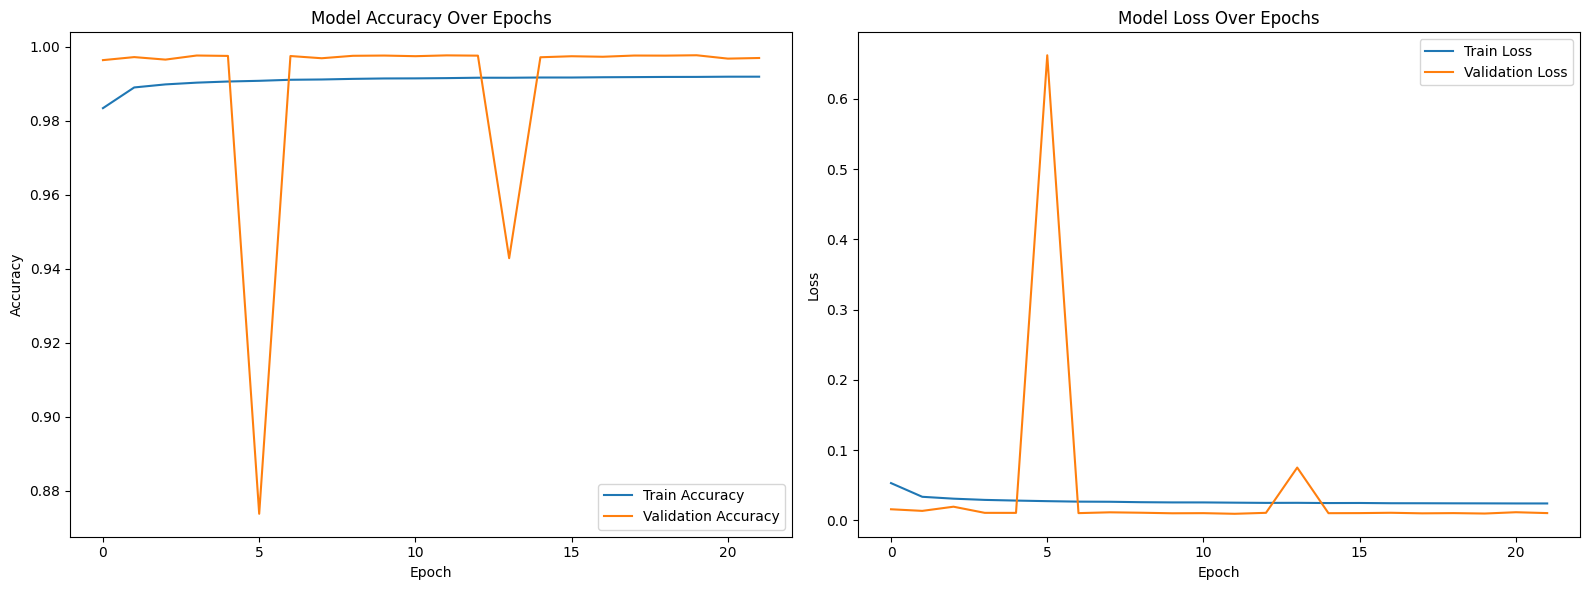

In [66]:
# plots training and validation accuracy and loss

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# plot: training & validation accuracy values
ax1.plot(history.history['acc'], label='Train Accuracy')
ax1.plot(history.history['val_acc'], label='Validation Accuracy')
ax1.set_title('Model Accuracy Over Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# plot: training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss Over Epochs')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [67]:
# get CNN probabilities and hard predictions (VAL + TEST)
probs_val  = best_model.predict(X_val_seq,  verbose=0)
probs_test = best_model.predict(X_test_seq, verbose=0)

y_val_pred  = probs_val.argmax(axis=1)
y_test_pred = probs_test.argmax(axis=1)


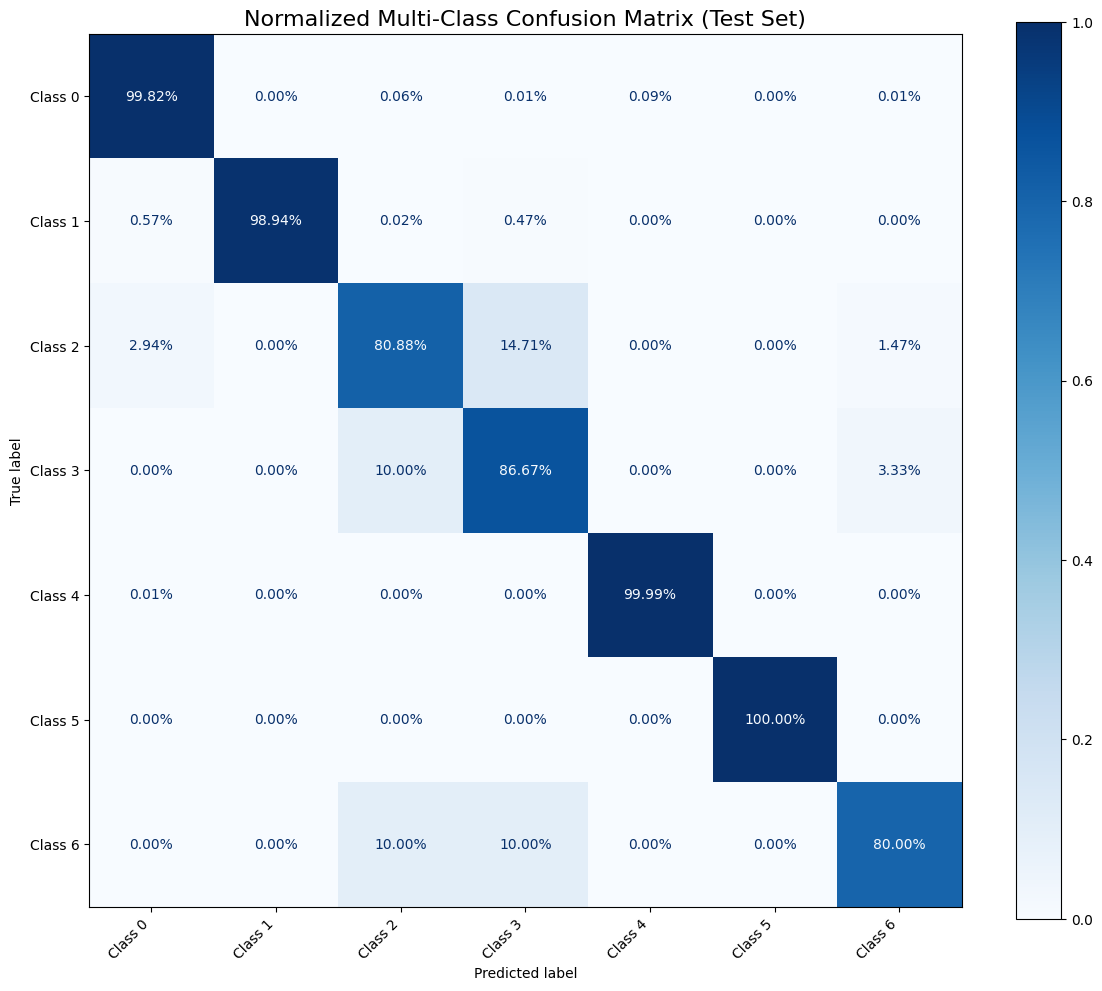

In [38]:
#  Normalized Multi-Class Confusion Matrix (Test Set)
class_names = [f'Class {i}' for i in range(num_classes)]

cm_multi_normalized = confusion_matrix(y_test, y_test_pred, normalize='true')

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_normalized, display_labels=class_names)

disp.plot(ax=ax, cmap='Blues', values_format='.2%')
plt.title('Normalized Multi-Class Confusion Matrix (Test Set)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

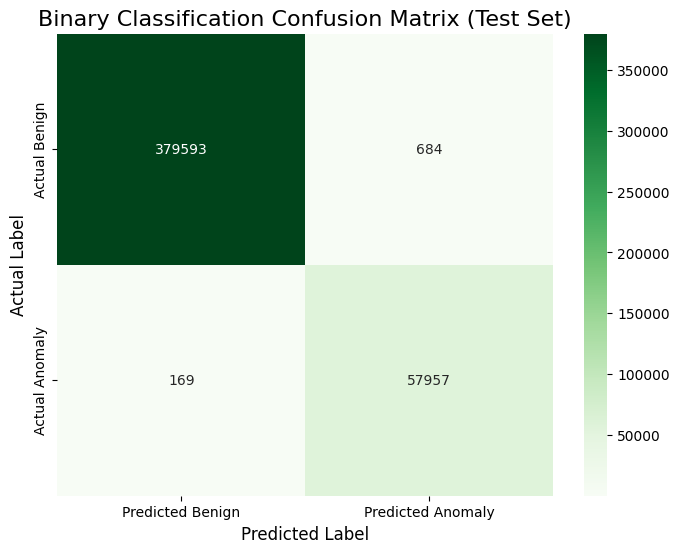

In [45]:
# Binary Classification Confusion Matrix

y_test_bin_true = (np.array(y_test) > 0).astype(int)
y_test_bin_pred = (y_test_pred > 0).astype(int)

# Calculate the binary confusion matrix
cm_binary = confusion_matrix(y_test_bin_true, y_test_bin_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Benign', 'Predicted Anomaly'],
            yticklabels=['Actual Benign', 'Actual Anomaly'])
plt.title('Binary Classification Confusion Matrix (Test Set)', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [ ]:
# CNN binary view: BENIGN(0) vs ATTACK(1)
# class id 0 == BENIGN; everything else == ATTACK.

y_val_bin_true  = (np.array(y_val)  != 0).astype(int)   
y_test_bin_true = (np.array(y_test) != 0).astype(int) 

y_val_bin_pred  = (y_val_pred  != 0).astype(int)       
y_test_bin_pred = (y_test_pred != 0).astype(int)   

print("CNN — Validation (binary: benign vs attack)")
print(classification_report(y_val_bin_true,  y_val_bin_pred,  digits=4)) 

print("CNN — Test (binary: benign vs attack)")
print(classification_report(y_test_bin_true, y_test_bin_pred, digits=4)) 


CNN — Validation (binary: benign vs attack)
              precision    recall  f1-score   support

           0     0.9996    0.9982    0.9989    228166
           1     0.9885    0.9971    0.9928     34876

    accuracy                         0.9981    263042
   macro avg     0.9940    0.9977    0.9958    263042
weighted avg     0.9981    0.9981    0.9981    263042

CNN — Test (binary: benign vs attack)
              precision    recall  f1-score   support

           0     0.9996    0.9982    0.9989    380277
           1     0.9882    0.9971    0.9926     58126

    accuracy                         0.9980    438403
   macro avg     0.9939    0.9976    0.9958    438403
weighted avg     0.9981    0.9980    0.9980    438403



In [ ]:
# CNN macro ROC-AUC for VAL + TEST

num_classes = probs_test.shape[1]                               
y_val_onehot  = np.eye(num_classes)[np.array(y_val)]            
y_test_onehot = np.eye(num_classes)[np.array(y_test)]           

macro_val_auc  = float(roc_auc_score(y_val_onehot,  probs_val,  multi_class="ovr", average="macro"))   # macro OvR AUC (VAL)
macro_test_auc = float(roc_auc_score(y_test_onehot, probs_test, multi_class="ovr", average="macro"))   # macro OvR AUC (TEST)

print({"cnn_macro_val_auc": macro_val_auc, "cnn_macro_test_auc": macro_test_auc})


{'cnn_macro_val_auc': 0.9997551227442915, 'cnn_macro_test_auc': 0.9973548750936787}


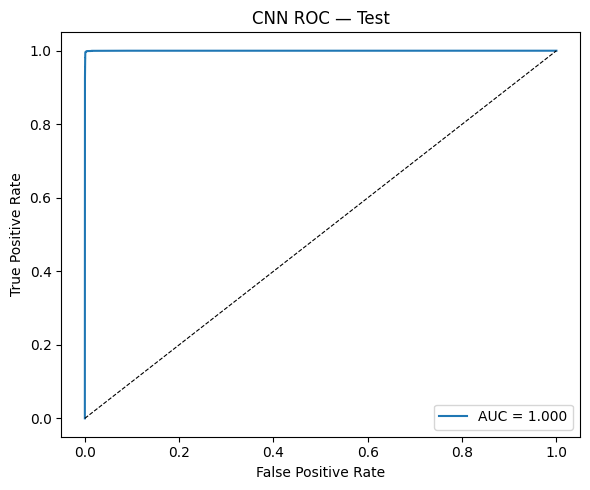

In [53]:
# plot ROC and print AUC
def plot_roc(y_true, scores, title="ROC"):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], "k--", linewidth=0.8)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title);
    plt.legend(loc="lower right");
    plt.tight_layout();
    plt.show()


cnn_scores_test = 1.0 - probs_test[:, 0]
plot_roc(y_test_bin_true, cnn_scores_test, "CNN ROC — Test")
